# Convergence

Here we demonstrate the convergence properties of some of the methods.

# ABM

In [25]:
%pylab inline --no-import-all
from pytimeode import interfaces

class State(interfaces.ArrayStateMixin):
    """Simple exponential problem."""
    interfaces.implements(interfaces.IStateForABMEvolvers)
    def __init__(self):
        self.data = np.array([1.0])
    
    def compute_dy(self, t, dy=None):
        if dy is None:
            dy = self.copy()
        else:
            dy[...] = self[...]
        return dy

Populating the interactive namespace from numpy and matplotlib


In [26]:
from pytimeode.evolvers import EvolverABM
errs = []
T = 1.0
y0 = State()

y_exact = y0[0]*np.exp(T)

Nts = 2**np.arange(1, 12)

def get_errors(Nts=Nts, **kw):
    errs = []
    for Nt in Nts:
        evolver = EvolverABM(y=y0, dt=T/Nt, **kw)
        evolver.evolve(Nt)
        errs.append(abs(evolver.y[0] - y_exact))
    return np.array(errs)

errs = get_errors()
errs_no_rk = get_errors(no_runge_kutta=True)

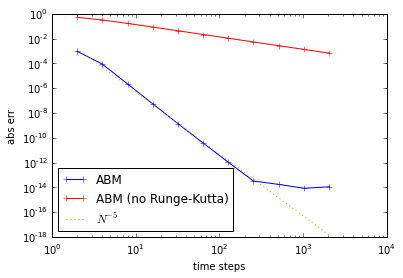

In [27]:
plt.loglog(Nts, errs, 'b+-', label='ABM')
plt.loglog(Nts, errs_no_rk, 'r+-', label='ABM (no Runge-Kutta)')
plt.loglog(Nts, 0.05/Nts**5, 'y:', label=r'$N^{-5}$')
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('abs err')

Here we plot the log of the errors as a function of number of timesteps demonstrating the $\order(\delta t^5)$ scaling of the errors for the ABM method.  Note that, if the function is not constant for the first few timesteps, the predictor-corrector arrays are not properly initialize and the evolution is not effective.

# Split Operator

To test the split-operator method, we consider a simple problem of evolution with the following Hamiltonian:

$$
  \I\pdiff{}{t} = \mat{K}\ket{\psi} + \mat{V}\ket{\psi}
$$

where $\mat{V} = \diag\abs{\psi}^2 + \mat{A}$ and $\mat{K}$ and $\mat{A}$ are random Hermitian matrices.

In [28]:
%pylab inline --no-import-all
import scipy.linalg
sp = scipy
from pytimeode import interfaces

class State(interfaces.ArrayStateMixin):
    """Simple 2D non-linear Schrodinger equation"""
    interfaces.implements(interfaces.IStateForABMEvolvers, interfaces.IStateForSplitEvolvers)
    def __init__(self):
        np.random.seed(1)
        shape = (2, 2)
        A = np.random.random(shape) + 1j*np.random.random(shape) - 0.5 - 0.5j
        K = np.random.random(shape) + 1j*np.random.random(shape) - 0.5 - 0.5j
        self.A = A + A.conj().T
        self.K = K + K.conj().T
        self.data = np.array([1.0, 0.0], dtype=complex)
    
    def compute_dy(self, t, dy=None):
        if dy is None:
            dy = self.copy()
            
        V = np.diag(self.get_potentials(t=t)) + self.A
        dy[...] = (self.K + V).dot(self[...])/1j
        return dy
    
    def get_potentials(self, t):
        """Return `potentials` at time `t`."""
        psi = self[...]
        return abs(psi)**2

    def apply_exp_K(self, dt, t=None):
        r"""Apply $e^{-i K dt}$ in place"""
        self[...] = sp.linalg.expm(-1j*self.K*dt).dot(self[...])

    def apply_exp_V(self, dt, state=None, t=None):
        r"""Apply $e^{-i V dt}$ in place"""
        potentials = state.get_potentials(t=t)
        V = np.diag(potentials) + self.A
        self[...] = sp.linalg.expm(-1j*V*dt).dot(self[...])

Populating the interactive namespace from numpy and matplotlib


For an "exact" solution we use the ABM evolver:

In [29]:
from pytimeode.evolvers import EvolverABM, EvolverSplit
errs = []
T = 1.0
y0 = State()

Nt = 2**12
evolver = EvolverABM(y=y0, dt=T/Nt)
evolver.evolve(Nt)
y_exact = evolver.y[...]

Nts = 2**np.arange(1, 12)

def get_errors(Evolver=EvolverABM, Nts=Nts, **kw):
    errs = []
    for Nt in Nts:
        evolver = Evolver(y=y0, dt=T/Nt, **kw)
        evolver.evolve(Nt)
        errs.append(abs(evolver.y[...] - y_exact).max())
    return np.array(errs)

errs = get_errors()
errs_split = get_errors(Evolver=EvolverSplit)

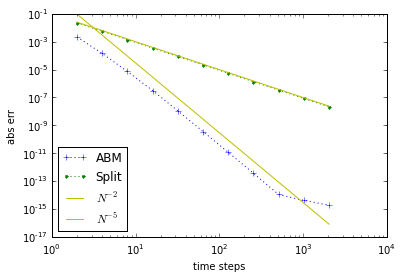

In [30]:
plt.loglog(Nts, errs, 'b+:', label='ABM')
plt.loglog(Nts, errs_split, 'g.:', label='Split')
plt.loglog(Nts, 0.1/Nts**2, 'y-', label=r'$N^{-2}$')
plt.loglog(Nts, 3./Nts**5, 'y-', label=r'$N^{-5}$')
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('abs err')